<a href="https://colab.research.google.com/github/shmoshe/nba-rookie-success/blob/main/Predicting_NBA_Success.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NBA Player Stats as Predictors of Individual Player and Team Success

In [1]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 43.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
import json
import os

!pip install kaggle

api_token = {"username":"shmoshe","key":"83ec08e296275f64eded7de823100245"}

!mkdir /root/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!mkdir ./datasets
!mkdir ./datasets/nba-stats

!kaggle datasets download drgilermo/nba-players-stats -p ./datasets/nba-stats
!unzip ./datasets/nba-stats/*.zip  -d ./datasets/nba-stats/

Dataset URL: https://www.kaggle.com/datasets/drgilermo/nba-players-stats
License(s): unknown
  0% 0.00/2.13M [00:00<?, ?B/s]
100% 2.13M/2.13M [00:00<00:00, 96.7MB/s]
Archive:  ./datasets/nba-stats/nba-players-stats.zip
  inflating: ./datasets/nba-stats/Players.csv  
  inflating: ./datasets/nba-stats/Seasons_Stats.csv  
  inflating: ./datasets/nba-stats/player_data.csv  


Player data is from https://www.kaggle.com/datasets/drgilermo/nba-players-stats for years 1950-2018.


In [4]:
import pandas as pd

nba_players_stats_df = pd.read_csv('./datasets/nba-stats/Players.csv').drop(columns=['Unnamed: 0', 'birth_city', 'birth_state', 'born'])
nba_player_data_df = pd.read_csv('./datasets/nba-stats/player_data.csv').drop(columns=['height', 'weight', 'college'])
nba_players_df = pd.merge(nba_players_stats_df, nba_player_data_df, left_on='Player', right_on='name', how='inner').drop('name', axis=1)
nba_players_df['career_length'] = nba_players_df.apply(lambda row: row['year_end'] - row['year_start'] + 1, axis=1)
nba_players_df = nba_players_df.rename(columns={'collage': 'college'})
nba_players_df['position'] = nba_players_df['position'].apply(lambda x: 'F-G' if x == 'G-F' else x)
nba_players_df['position'] = nba_players_df['position'].apply(lambda x: 'F-C' if x == 'C-F' else x)

nba_players_df

,Player,height,weight,college,year_start,year_end,position,birth_date,career_length
0,Curly Armstrong,180.0,77.0,Indiana University,1949,1951,F-G,"November 1, 1918",3
1,Cliff Barker,188.0,83.0,University of Kentucky,1950,1952,G,"January 15, 1921",3
2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1950,1954,F-G,"May 11, 1924",5
3,Ed Bartels,196.0,88.0,North Carolina State University,1950,1951,F,"October 8, 1925",2
4,Ralph Beard,178.0,79.0,University of Kentucky,1950,1951,G,"December 2, 1927",2
...,...,...,...,...,...,...,...,...,...
3809,Troy Williams,198.0,97.0,South Carolina State University,2017,2018,F,"December 30, 1994",2
3810,Kyle Wiltjer,208.0,108.0,Gonzaga University,2017,2017,F,"October 20, 1992",1
3811,Stephen Zimmerman,213.0,108.0,"University of Nevada, Las Vegas",2017,2017,C,"September 9, 1996",1
3812,Paul Zipser,203.0,97.0,NaN,2017,2018,F-G,"February 18, 1994",2


In [5]:
nba_seasons_stats_df = pd.read_csv('./datasets/nba-stats/Seasons_Stats.csv').drop('Unnamed: 0', axis=1)
nba_seasons_stats_df

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24686,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,0.604,...,0.679,135.0,270.0,405.0,99.0,62.0,58.0,65.0,189.0,639.0
24687,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,0.508,...,0.564,43.0,81.0,124.0,42.0,7.0,21.0,20.0,61.0,178.0
24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,...,0.600,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0
24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,...,0.775,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0


## Adding Success Attributes to Dataframe

In [6]:
# average career length of an NBA player

average_career_length = nba_players_df['career_length'].mean()
max_career_length = nba_players_df['career_length'].max()
print(f'Average player career length: {average_career_length} years')
print(f'Max player career length: {max_career_length} years')

Average player career length: 5.471421080230729 years
Max player career length: 23 years


In [7]:
# points each player makes per season on average

avg_points_per_season = nba_seasons_stats_df.groupby('Player')['PTS'].mean()
nba_players_df['avg_points_per_season'] = nba_players_df.apply(lambda row: avg_points_per_season[row['Player']], axis=1)
average_points_per_season = nba_players_df['avg_points_per_season'].mean()
max_points_per_season = nba_players_df['avg_points_per_season'].max()
print(f'Average points per season: {average_points_per_season}')
print(f'Max points per season: {max_points_per_season}')

Average points per season: 304.49146048546726
Max points per season: 2056.214285714286


In [8]:
# number of games each player plays per season on average

avg_num_games_per_season = nba_seasons_stats_df.groupby('Player')['G'].mean()
nba_players_df['avg_num_games_per_season'] = nba_players_df.apply(lambda row: avg_num_games_per_season[row['Player']], axis=1)
average_games_per_season = nba_players_df['avg_num_games_per_season'].mean()
max_games_per_season = nba_players_df['avg_num_games_per_season'].max()
print(f'Average number of games per season: {average_games_per_season}')
print(f'Max number of games per season: {max_games_per_season}')

Average number of games per season: 39.75289400843391
Max number of games per season: 82.0


In [9]:
# number of minutes each player plays per season on average

avg_num_minutes_played_per_season = nba_seasons_stats_df.groupby('Player')['MP'].mean()
nba_players_df['avg_num_minutes_played_per_season'] = nba_players_df.apply(lambda row: avg_num_minutes_played_per_season[row['Player']], axis=1)
average_minutes_played_per_season = nba_players_df['avg_num_minutes_played_per_season'].mean()
max_minutes_played_per_season = nba_players_df['avg_num_minutes_played_per_season'].max()
print(f'Average number of minutes played per season: {average_minutes_played_per_season}')
print(f'Max number of minutes played per season: {max_minutes_played_per_season}')

Average number of minutes played per season: 777.481265018501
Max number of minutes played per season: 2954.0


In [10]:
# average free throw percent per season per player

avg_free_throw_percent_per_season = nba_seasons_stats_df.groupby('Player')['FT%'].mean()
nba_players_df['avg_FT%'] = nba_players_df.apply(lambda row: avg_free_throw_percent_per_season[row['Player']], axis=1)
average_free_throw_percentage = nba_players_df['avg_FT%'].mean()
max_free_throw_percentage = nba_players_df['avg_FT%'].max()
print(f'Average free throw percentage: {average_free_throw_percentage}')
print(f'Max free throw percentage: {max_free_throw_percentage}')

Average free throw percentage: 0.6910301562573811
Max free throw percentage: 1.0


In [11]:
# average number of rebounds per season per player

avg_rebounds_per_season = nba_seasons_stats_df.groupby('Player')['TRB'].mean()
nba_players_df['avg_rebounds'] = nba_players_df.apply(lambda row: avg_rebounds_per_season[row['Player']], axis=1)
average_rebounds_per_season = nba_players_df['avg_rebounds'].mean()
max_rebounds_per_season = nba_players_df['avg_rebounds'].max()
print(f'Average rebounds per season: {average_rebounds_per_season}')
print(f'Max rebounds per season: {max_rebounds_per_season}')

Average rebounds per season: 139.2768850709876
Max rebounds per season: 989.2


In [12]:
# average number of assists per season per player

avg_assists_per_season = nba_seasons_stats_df.groupby('Player')['AST'].mean()
nba_players_df['avg_assists'] = nba_players_df.apply(lambda row: avg_assists_per_season[row['Player']], axis=1)
average_assists_per_season = nba_players_df['avg_assists'].mean()
max_assists_per_season = nba_players_df['avg_assists'].max()
print(f'Average assists per season: {average_assists_per_season}')
print(f'Max assists per season: {max_assists_per_season}')

Average assists per season: 69.71464222364776
Max assists per season: 687.5833333333334


In [13]:
# average number of steals per season per player

avg_steals_per_season = nba_seasons_stats_df.groupby('Player')['STL'].mean()
nba_players_df['avg_steals'] = nba_players_df.apply(lambda row: avg_steals_per_season[row['Player']], axis=1)
average_steals_per_season = nba_players_df['avg_steals'].mean()
max_steals_per_season = nba_players_df['avg_steals'].max()
print(f'Average steals per season: {average_steals_per_season}')
print(f'Max steals per season: {max_steals_per_season}')

Average steals per season: 26.777436773844993
Max steals per season: 188.91666666666666


In [14]:
# average number of blocks per season per player

avg_blocks_per_season = nba_seasons_stats_df.groupby('Player')['BLK'].mean()
nba_players_df['avg_blocks'] = nba_players_df.apply(lambda row: avg_blocks_per_season[row['Player']], axis=1)
average_blocks_per_season = nba_players_df['avg_blocks'].mean()
max_blocks_per_season = nba_players_df['avg_blocks'].max()
print(f'Average blocks per season: {average_blocks_per_season}')
print(f'Max blocks per season: {max_blocks_per_season}')

Average blocks per season: 15.462954654910554
Max blocks per season: 278.54545454545456


In [15]:
# average field goal percentage per season per player

avg_field_goal_percentage_per_season = nba_seasons_stats_df.groupby('Player')['FG%'].mean()
nba_players_df['avg_FG%'] = nba_players_df.apply(lambda row: avg_field_goal_percentage_per_season[row['Player']], axis=1)
average_field_goal_percentage = nba_players_df['avg_FG%'].mean()
max_field_goal_percentage = nba_players_df['avg_FG%'].max()
print(f'Average field goal percentage: {average_field_goal_percentage}')
print(f'Max field goal percentage: {max_field_goal_percentage}')

Average field goal percentage: 0.4025693155350922
Max field goal percentage: 1.0


In [16]:
# average 3-point percentage per season per player

avg_3_point_percentage_per_season = nba_seasons_stats_df.groupby('Player')['3P%'].mean()
nba_players_df['avg_3P%'] = nba_players_df.apply(lambda row: avg_3_point_percentage_per_season[row['Player']], axis=1)
average_3_point_percentage = nba_players_df['avg_3P%'].mean()
max_3_point_percentage = nba_players_df['avg_3P%'].max()
print(f'Average 3-point percentage: {average_3_point_percentage}')
print(f'Max 3-point percentage: {max_3_point_percentage}')

Average 3-point percentage: 0.22090211062503123
Max 3-point percentage: 1.0


In [17]:
# average turnovers per season per player

avg_turnovers_per_season = nba_seasons_stats_df.groupby('Player')['TOV'].mean()
nba_players_df['avg_turnovers'] = nba_players_df.apply(lambda row: avg_turnovers_per_season[row['Player']], axis=1)
average_turnovers_per_season = nba_players_df['avg_turnovers'].mean()
max_turnovers_per_season = nba_players_df['avg_turnovers'].max()
print(f'Average turnovers per season: {average_turnovers_per_season}')
print(f'Max turnovers per season: {max_turnovers_per_season}')

Average turnovers per season: 49.831497220157274
Max turnovers per season: 291.1111111111111


In [18]:
# average player efficiency rating per season per player

avg_efficiency_rating_per_season = nba_seasons_stats_df.groupby('Player')['PER'].mean()
nba_players_df['avg_efficiency'] = nba_players_df.apply(lambda row: avg_efficiency_rating_per_season[row['Player']], axis=1)
average_efficiency_rating = nba_players_df['avg_efficiency'].mean()
max_efficiency_rating = nba_players_df['avg_efficiency'].max()
print(f'Average efficiency rating: {average_efficiency_rating}')
print(f'Max efficiency rating: {max_efficiency_rating}')

Average efficiency rating: 10.484530253987673
Max efficiency rating: 88.3


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# add in awards, hall of fame, championship information

nba_awards_df = pd.read_csv('./drive/MyDrive/nba_player_awards_data.csv').drop(columns=['Unnamed: 0']).drop_duplicates(subset=['Player'])
nba_awards_df

,Player,Hall_of_Fame,Awards,All_Star,Championships,All_Nbas
0,Curly Armstrong,False,0,0,0,0
1,Cliff Barker,False,0,0,0,0
2,Leo Barnhorst,False,0,2,0,0
3,Ed Bartels,False,0,0,0,0
4,Ralph Beard,False,0,1,0,1
...,...,...,...,...,...,...
3806,Enes Kanter,False,0,0,0,0
3807,Dewayne Dedmon,False,0,0,0,0
3808,C.J. McCollum,False,1,0,0,0
3809,James Southerland,False,0,0,0,0


In [21]:
nba_players_df.drop_duplicates(subset=['Player'], inplace=True)
nba_players_df = pd.merge(nba_players_df, nba_awards_df, left_on='Player', right_on='Player', how='inner')
nba_players_df

,Player,height,weight,college,year_start,year_end,position,birth_date,career_length,avg_points_per_season,...,avg_blocks,avg_FG%,avg_3P%,avg_turnovers,avg_efficiency,Hall_of_Fame,Awards,All_Star,Championships,All_Nbas
0,Curly Armstrong,180.0,77.0,Indiana University,1949,1951,F-G,"November 1, 1918",3,330.000000,...,NaN,0.294500,NaN,NaN,NaN,False,0,0,0,0
1,Cliff Barker,188.0,83.0,University of Kentucky,1950,1952,G,"January 15, 1921",3,185.666667,...,NaN,0.307333,NaN,NaN,10.800000,False,0,0,0,0
2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1950,1954,F-G,"May 11, 1924",5,646.400000,...,NaN,0.362200,NaN,NaN,15.950000,False,0,2,0,0
3,Ed Bartels,196.0,88.0,North Carolina State University,1950,1951,F,"October 8, 1925",2,49.500000,...,NaN,0.252250,NaN,NaN,NaN,False,0,0,0,0
4,Ralph Beard,178.0,79.0,University of Kentucky,1950,1951,G,"December 2, 1927",2,1003.000000,...,NaN,0.365500,NaN,NaN,NaN,False,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3757,Troy Williams,198.0,97.0,South Carolina State University,2017,2018,F,"December 30, 1994",2,123.333333,...,6.666667,0.450667,0.305,22.0,9.766667,False,0,0,0,0
3758,Kyle Wiltjer,208.0,108.0,Gonzaga University,2017,2017,F,"October 20, 1992",1,13.000000,...,1.000000,0.286000,0.308,5.0,6.700000,False,0,0,0,0
3759,Stephen Zimmerman,213.0,108.0,"University of Nevada, Las Vegas",2017,2017,C,"September 9, 1996",1,23.000000,...,5.000000,0.323000,NaN,3.0,7.300000,False,0,0,0,0
3760,Paul Zipser,203.0,97.0,NaN,2017,2018,F-G,"February 18, 1994",2,240.000000,...,16.000000,0.398000,0.333,40.0,6.900000,False,0,0,0,0


This scoring system was chosen for a few reasons:
1. Emphasizing the importance of a Hall of Fame induction. In the history of basketball, only 436 players, coaches, referees, and other basketball professionals have been inducted into the Hall of Fame out of many thousands. Because of how hard it is to get into the Hall of Fame, and how greatly this indicates a successful career in basketball, players who have been inducted into the Hall of Fame get an additional 10 success points.
2. Emphasizing the importance of winning a championship. Each season, the end goal of every player and every team is to win the championship, and those players and teams who have won championships are considered to be highly successful. Therefore, 5 success points are given for each championship a player has won.
3. How extremely challenging it is to be in the top 25% for any player stats such as rebounds, assists, points, etc. A large number of stats were chosen as contributing to being successful because not all successful players are at the top of all categories. There are those players that have amazing 3-point numbers and percentages, such as Stephen Curry, but who are not in the top 25% in other statistics such as rebounds. Thus, we gave 2 success points to those who made it into the top 25% of a category and 1 success point for those who were in the top 25-50%.
4. Lastly, we gave 3 success points for each award, all-stars, and all-nbas because these awards are given to the top players in their respective domains. The goal of these awards is to give accolades to the top players of the season. Therefore, 3 success points were given per award, all-star, and all-nba in order to emphasize the fact that these accolades are more indicative of a successful career than achieving the top 25% of a statistical category, but have less importance than winning a championship. In addition, the people who choose those who receive the awards are peers and professionals in the field that acknowledge the impressive contribution made by the recipient.

In [22]:
# +1 success point for being above average, +2 success points for being in top 25% of a category
# +3 success point for each award, all-star or all-nba
# +5 success points for winning a championship, +10 success points for being in the Hall of Fame

def top_25_percentile(column):
  return column.quantile(0.75)

def determine_player_success(row):
  success_points = 0

  success_points += (3* row['Awards'])
  success_points += (3* row['All_Star'])
  success_points += (3* row['All_Nbas'])
  success_points += (5 * row['Championships'])

  if(row['Hall_of_Fame'] == True):
    success_points += 10

  if (row['career_length'] > average_career_length):
    success_points += 1

    if (row['career_length'] > top_25_percentile(nba_players_df['career_length'])):
      success_points += 1

  if (row['avg_num_games_per_season'] > average_games_per_season):
    success_points += 1

    if (row['avg_num_games_per_season'] > top_25_percentile(nba_players_df['avg_num_games_per_season'])):
      success_points += 1

  if (row['avg_num_minutes_played_per_season'] > average_minutes_played_per_season):
    success_points += 1

    if (row['avg_num_minutes_played_per_season'] > top_25_percentile(nba_players_df['avg_num_minutes_played_per_season'])):
      success_points += 1

  if(row['avg_points_per_season'] > average_points_per_season):
    success_points += 1

    if (row['avg_points_per_season'] > top_25_percentile(nba_players_df['avg_points_per_season'])):
      success_points += 1

  if (row['avg_FT%'] > average_free_throw_percentage):
    success_points += 1

    if(row['avg_FT%'] > top_25_percentile(nba_players_df['avg_FT%'])):
      success_points += 1

  if(row['avg_rebounds'] > average_rebounds_per_season):
    success_points += 1

    if(row['avg_rebounds'] > top_25_percentile(nba_players_df['avg_rebounds'])):
      success_points += 1

  if(row['avg_assists'] > average_assists_per_season):
    success_points += 1

    if(row['avg_assists'] > top_25_percentile(nba_players_df['avg_assists'])):
      success_points += 1

  if(row['avg_steals'] > average_steals_per_season):
    success_points += 1

    if(row['avg_steals'] > top_25_percentile(nba_players_df['avg_steals'])):
      success_points += 1

  if(row['avg_blocks'] > average_blocks_per_season):
    success_points += 1

    if(row['avg_blocks'] > top_25_percentile(nba_players_df['avg_blocks'])):
      success_points += 1

  if(row['avg_FG%'] > average_field_goal_percentage):
    success_points += 1

    if(row['avg_FG%'] > top_25_percentile(nba_players_df['avg_FG%'])):
      success_points += 1

  if(row['avg_3P%'] > average_3_point_percentage):
    success_points += 1

    if(row['avg_3P%'] > top_25_percentile(nba_players_df['avg_3P%'])):
      success_points += 1

  if(row['avg_turnovers'] > average_turnovers_per_season):
    success_points += 1

    if(row['avg_turnovers'] > top_25_percentile(nba_players_df['avg_turnovers'])):
      success_points += 1

  if(row['avg_efficiency'] > average_efficiency_rating):
    success_points += 1

    if(row['avg_efficiency'] > top_25_percentile(nba_players_df['avg_efficiency'])):
      success_points += 1

  return success_points

nba_players_df['success'] = nba_players_df.apply(determine_player_success, axis=1)
nba_players_df

,Player,height,weight,college,year_start,year_end,position,birth_date,career_length,avg_points_per_season,...,avg_FG%,avg_3P%,avg_turnovers,avg_efficiency,Hall_of_Fame,Awards,All_Star,Championships,All_Nbas,success
0,Curly Armstrong,180.0,77.0,Indiana University,1949,1951,F-G,"November 1, 1918",3,330.000000,...,0.294500,NaN,NaN,NaN,False,0,0,0,0,4
1,Cliff Barker,188.0,83.0,University of Kentucky,1950,1952,G,"January 15, 1921",3,185.666667,...,0.307333,NaN,NaN,10.800000,False,0,0,0,0,4
2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1950,1954,F-G,"May 11, 1924",5,646.400000,...,0.362200,NaN,NaN,15.950000,False,0,2,0,0,18
3,Ed Bartels,196.0,88.0,North Carolina State University,1950,1951,F,"October 8, 1925",2,49.500000,...,0.252250,NaN,NaN,NaN,False,0,0,0,0,0
4,Ralph Beard,178.0,79.0,University of Kentucky,1950,1951,G,"December 2, 1927",2,1003.000000,...,0.365500,NaN,NaN,NaN,False,0,1,0,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3757,Troy Williams,198.0,97.0,South Carolina State University,2017,2018,F,"December 30, 1994",2,123.333333,...,0.450667,0.305,22.0,9.766667,False,0,0,0,0,3
3758,Kyle Wiltjer,208.0,108.0,Gonzaga University,2017,2017,F,"October 20, 1992",1,13.000000,...,0.286000,0.308,5.0,6.700000,False,0,0,0,0,1
3759,Stephen Zimmerman,213.0,108.0,"University of Nevada, Las Vegas",2017,2017,C,"September 9, 1996",1,23.000000,...,0.323000,NaN,3.0,7.300000,False,0,0,0,0,0
3760,Paul Zipser,203.0,97.0,NaN,2017,2018,F-G,"February 18, 1994",2,240.000000,...,0.398000,0.333,40.0,6.900000,False,0,0,0,0,6


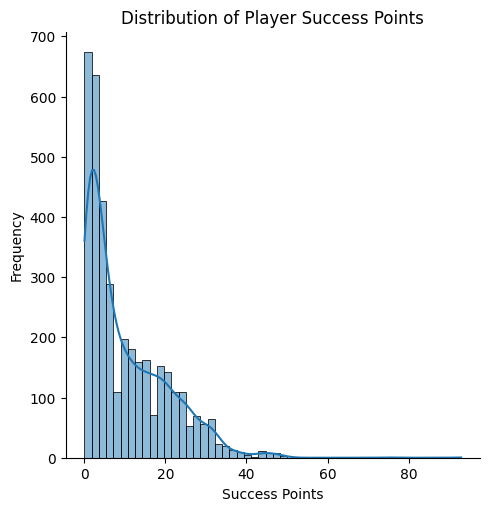

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(nba_players_df['success'], kde=True)
plt.title('Distribution of Player Success Points')
plt.xlabel('Success Points')
plt.ylabel('Frequency')
plt.show()


## Simple Predictive Model

We decided to use a random forest model for a few reasons:
1. No assumption of a linear relationship between features and the outcome (top player)
2. Handling of missing feature values - many players don't have data for certain statistics (rebounds, assists, etc) but we wanted to include these players in the dataset since they could still be considered successful
3. Higher predictive accuracy and less overfitting than if we used just one decision tree

In [24]:
average_success_points = nba_players_df['success'].mean()
max_success_points = nba_players_df['success'].max()
top_25th_percentile = top_25_percentile(nba_players_df['success'])

print(f'Average success points: {average_success_points}')
print(f'Max success points: {max_success_points}')
print(f'Top 25th percentile: {top_25th_percentile}')

def determine_top_players(row):
  success_level = 'player'

  if (row['success'] > top_25th_percentile):
    success_level = 'top_25_player'

  return success_level

nba_players_df['top_player'] = nba_players_df.apply(determine_top_players, axis=1)
nba_players_df

Average success points: 10.125465178096757
Max success points: 93
Top 25th percentile: 16.0


,Player,height,weight,college,year_start,year_end,position,birth_date,career_length,avg_points_per_season,...,avg_3P%,avg_turnovers,avg_efficiency,Hall_of_Fame,Awards,All_Star,Championships,All_Nbas,success,top_player
0,Curly Armstrong,180.0,77.0,Indiana University,1949,1951,F-G,"November 1, 1918",3,330.000000,...,NaN,NaN,NaN,False,0,0,0,0,4,player
1,Cliff Barker,188.0,83.0,University of Kentucky,1950,1952,G,"January 15, 1921",3,185.666667,...,NaN,NaN,10.800000,False,0,0,0,0,4,player
2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1950,1954,F-G,"May 11, 1924",5,646.400000,...,NaN,NaN,15.950000,False,0,2,0,0,18,top_25_player
3,Ed Bartels,196.0,88.0,North Carolina State University,1950,1951,F,"October 8, 1925",2,49.500000,...,NaN,NaN,NaN,False,0,0,0,0,0,player
4,Ralph Beard,178.0,79.0,University of Kentucky,1950,1951,G,"December 2, 1927",2,1003.000000,...,NaN,NaN,NaN,False,0,1,0,1,15,player
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3757,Troy Williams,198.0,97.0,South Carolina State University,2017,2018,F,"December 30, 1994",2,123.333333,...,0.305,22.0,9.766667,False,0,0,0,0,3,player
3758,Kyle Wiltjer,208.0,108.0,Gonzaga University,2017,2017,F,"October 20, 1992",1,13.000000,...,0.308,5.0,6.700000,False,0,0,0,0,1,player
3759,Stephen Zimmerman,213.0,108.0,"University of Nevada, Las Vegas",2017,2017,C,"September 9, 1996",1,23.000000,...,NaN,3.0,7.300000,False,0,0,0,0,0,player
3760,Paul Zipser,203.0,97.0,NaN,2017,2018,F-G,"February 18, 1994",2,240.000000,...,0.333,40.0,6.900000,False,0,0,0,0,6,player


In [25]:
rookie_seasons_df = nba_seasons_stats_df.groupby('Player').head(1).copy().drop_duplicates(subset=['Player'])
rookie_seasons_df = rookie_seasons_df[rookie_seasons_df['Player'].isin(nba_awards_df['Player'].unique())]
rookie_seasons_df

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
6,1950.0,Ralph Beard,G,22.0,INO,60.0,NaN,NaN,NaN,0.422,...,0.762,NaN,NaN,NaN,233.0,NaN,NaN,NaN,132.0,895.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24672,2017.0,Troy Williams,SF,22.0,TOT,30.0,16.0,557.0,8.9,0.511,...,0.656,15.0,54.0,69.0,25.0,27.0,10.0,33.0,60.0,185.0
24675,2017.0,Kyle Wiltjer,PF,24.0,HOU,14.0,0.0,44.0,6.7,0.437,...,0.500,4.0,6.0,10.0,2.0,3.0,1.0,5.0,4.0,13.0
24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,...,0.600,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0
24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,...,0.775,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0


In [26]:
rookie_seasons_df = rookie_seasons_df.merge(nba_players_df[['Player', 'college', 'position', 'top_player']], on='Player', how='left')
rookie_seasons_df

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,TRB,AST,STL,BLK,TOV,PF,PTS,college,position,top_player
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,...,NaN,176.0,NaN,NaN,NaN,217.0,458.0,Indiana University,F-G,player
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,...,NaN,109.0,NaN,NaN,NaN,99.0,279.0,University of Kentucky,G,player
2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,...,NaN,140.0,NaN,NaN,NaN,192.0,438.0,University of Notre Dame,F-G,top_25_player
3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,...,NaN,20.0,NaN,NaN,NaN,29.0,63.0,North Carolina State University,F,player
4,1950.0,Ralph Beard,G,22.0,INO,60.0,NaN,NaN,NaN,0.422,...,NaN,233.0,NaN,NaN,NaN,132.0,895.0,University of Kentucky,G,player
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3757,2017.0,Troy Williams,SF,22.0,TOT,30.0,16.0,557.0,8.9,0.511,...,69.0,25.0,27.0,10.0,33.0,60.0,185.0,South Carolina State University,F,player
3758,2017.0,Kyle Wiltjer,PF,24.0,HOU,14.0,0.0,44.0,6.7,0.437,...,10.0,2.0,3.0,1.0,5.0,4.0,13.0,Gonzaga University,F,player
3759,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,...,35.0,4.0,2.0,5.0,3.0,17.0,23.0,"University of Nevada, Las Vegas",C,player
3760,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,...,125.0,36.0,15.0,16.0,40.0,78.0,240.0,NaN,F-G,player


In [27]:
# preprocessing for the classifier
import numpy as np
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
rookie_seasons_df['college_num'] = le.fit_transform(rookie_seasons_df['college'])
rookie_seasons_df['position_num'] = le.fit_transform(rookie_seasons_df['position'])

rookie_seasons_df = rookie_seasons_df.drop(['Player', 'Year', 'Pos', 'Tm', 'blank2', 'position', 'college'], axis=1)
rookie_seasons_df = rookie_seasons_df.replace(np.nan, None)
rookie_seasons_df

,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,...,TRB,AST,STL,BLK,TOV,PF,PTS,top_player,college_num,position_num
0,31.0,63.0,None,None,None,0.368,None,0.467,None,None,...,None,176.0,None,None,None,217.0,458.0,player,126,3
1,29.0,49.0,None,None,None,0.435,None,0.387,None,None,...,None,109.0,None,None,None,99.0,279.0,player,306,4
2,25.0,67.0,None,None,None,0.394,None,0.259,None,None,...,None,140.0,None,None,None,192.0,438.0,top_25_player,336,3
3,24.0,15.0,None,None,None,0.312,None,0.395,None,None,...,None,20.0,None,None,None,29.0,63.0,player,188,1
4,22.0,60.0,None,None,None,0.422,None,0.301,None,None,...,None,233.0,None,None,None,132.0,895.0,player,306,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3757,22.0,30.0,16.0,557.0,8.9,0.511,0.371,0.192,3.0,11.2,...,69.0,25.0,27.0,10.0,33.0,60.0,185.0,player,240,1
3758,24.0,14.0,0.0,44.0,6.7,0.437,0.929,0.143,9.9,14.9,...,10.0,2.0,3.0,1.0,5.0,4.0,13.0,player,108,1
3759,20.0,19.0,0.0,108.0,7.3,0.346,0.0,0.161,10.8,24.9,...,35.0,4.0,2.0,5.0,3.0,17.0,23.0,player,326,0
3760,22.0,44.0,18.0,843.0,6.9,0.503,0.448,0.181,1.9,14.2,...,125.0,36.0,15.0,16.0,40.0,78.0,240.0,player,416,3


In [28]:
# number each type of player in top_player column

print(nba_players_df['top_player'].value_counts())

top_player
player           2832
top_25_player     930
Name: count, dtype: int64


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

train, test = train_test_split(rookie_seasons_df, test_size=0.2, random_state=42)
X_train = train.drop("top_player", axis=1)
X_test = test.drop("top_player", axis=1)
y_train = train["top_player"].values
y_test = test["top_player"].values

random_forest_clf = RandomForestClassifier(random_state=0, n_jobs=-1)

random_forest_clf.fit(X_train, y_train)
y_predict = random_forest_clf.predict(X_test)

results = {'Random forest testing accuracy': accuracy_score(y_test, y_predict)}
results

{'Random forest testing accuracy': 0.8406374501992032}

## Model Results Analysis

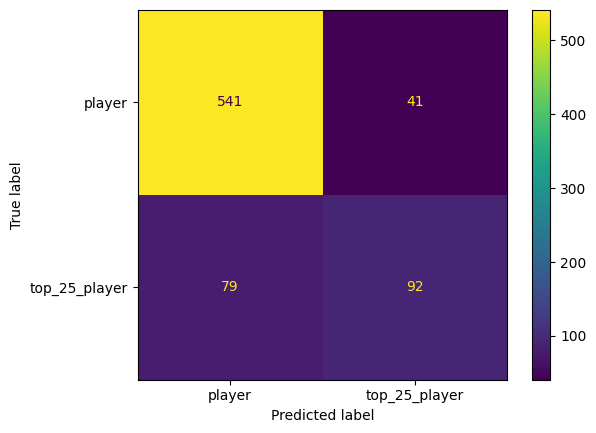

In [30]:
cm = confusion_matrix(y_test, y_predict, labels=random_forest_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_forest_clf.classes_)
disp.plot()

* Precision is the number of correctly identified members of a class divided by the number of times the model predicted that class - describes if it labeled things that aren't of a class as that class.

* Recall is the number of members of a class that the model correctly identified divided by the total number of members of that class - percentage of the class that was correctly identified.

* F1 combines both precision and recall. If both precision and recall are high, F1 will be high and if both are low, F1 will be low. If one is high and the other low, F1 will also be low.

For the player category, NBA players below the 75th percentile in success points, the model correctly identifies a high percentage of the data with 0.93 recall but sometimes incorrectly labels other player types as shown with the 0.87 precision, giving us a total F1 score of 0.90.

In the top 25th percentile category, the model's precision is better than its recall, meaning that it was better at not labeling other player types as top 25% but did not correctly predict a high percentage of the actual top 25% players. Both precision and recall scores for the top 25th percentile were worse than the player category with an F1 score of 0.61.

In [31]:
print(classification_report(y_test, y_predict))

               precision    recall  f1-score   support

       player       0.87      0.93      0.90       582
top_25_player       0.69      0.54      0.61       171

     accuracy                           0.84       753
    macro avg       0.78      0.73      0.75       753
 weighted avg       0.83      0.84      0.83       753



### Features Importance

Mean Decrease in Impurity (MDI) counts the number of times a feature is used to split a node, weighted by the number of samples it splits. It is used as a measure of feature importance, where the higher the MDI, the more important the feature for the prediction.

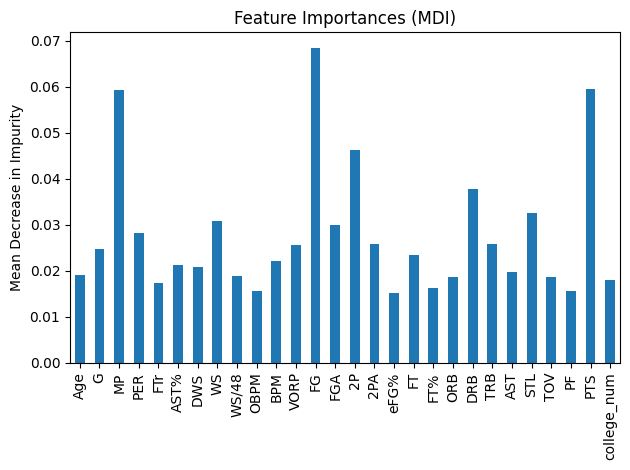

In [32]:
import matplotlib.pyplot as plt

feature_names = X_train.columns
importances = random_forest_clf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances_filtered = forest_importances[forest_importances > 0.015]

fig, ax = plt.subplots()
forest_importances_filtered.plot.bar(ax=ax)
ax.set_title("Feature Importances (MDI)")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

##Success According to Position

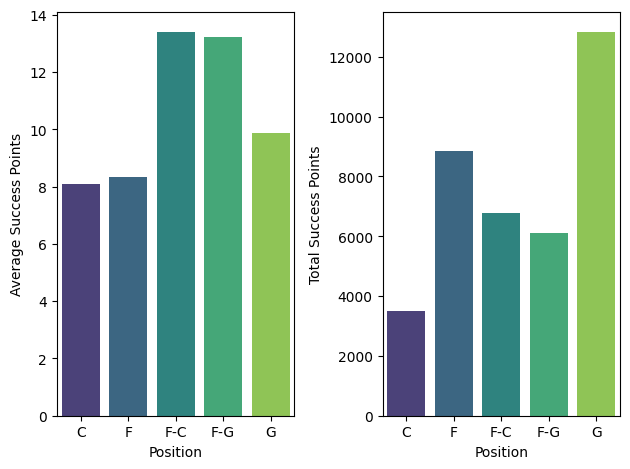

In [33]:
import matplotlib.pyplot as plt
position_success = nba_players_df.groupby('position')['success'].mean()
position_success_total = nba_players_df.groupby('position')['success'].sum()

fig, axes = plt.subplots(1, 2)

sns.barplot(x=position_success.index, y=position_success.values, hue=position_success.index, legend=False, palette='viridis', ax=axes[0])
# axes[0].set_title('Average Success Points by Position')
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Average Success Points')

sns.barplot(x=position_success_total.index, y=position_success_total.values, hue=position_success.index, legend=False, palette='viridis', ax=axes[1])
# axes[1].set_title('Total Success Points by Position')
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Total Success Points')
plt.tight_layout()
plt.show()

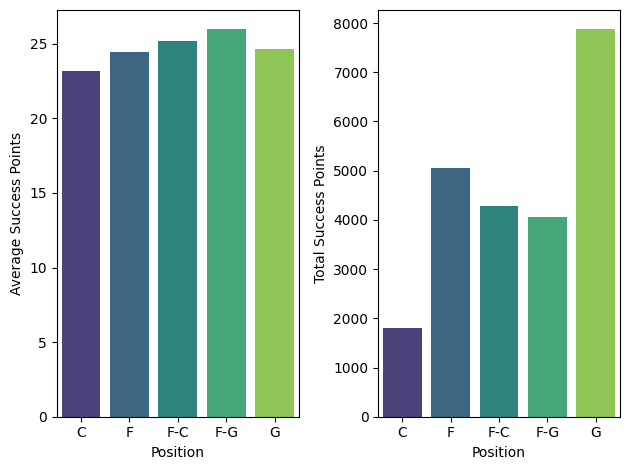

In [34]:
import matplotlib.pyplot as plt
position_success_top_25 = nba_players_df[nba_players_df['top_player'] == 'top_25_player'].groupby('position')['success'].mean()
position_success_total_top_25 = nba_players_df[nba_players_df['top_player'] == 'top_25_player'].groupby('position')['success'].sum()

fig, axes = plt.subplots(1, 2)

sns.barplot(x=position_success_top_25.index, y=position_success_top_25.values, hue=position_success_top_25.index, legend=False, palette='viridis', ax=axes[0])
# axes[0].set_title('Average Success Points by Position (Top 25%)')
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Average Success Points')

sns.barplot(x=position_success_total_top_25.index, y=position_success_total_top_25.values, hue=position_success_top_25.index, legend=False, palette='viridis', ax=axes[1])
# axes[1].set_title('Total Success Points by Position (Top 25%)')
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Total Success Points')
plt.tight_layout()
plt.show()


position
C      0.180556
F      0.194915
F-C    0.336634
F-G    0.337662
G      0.245385
dtype: float64


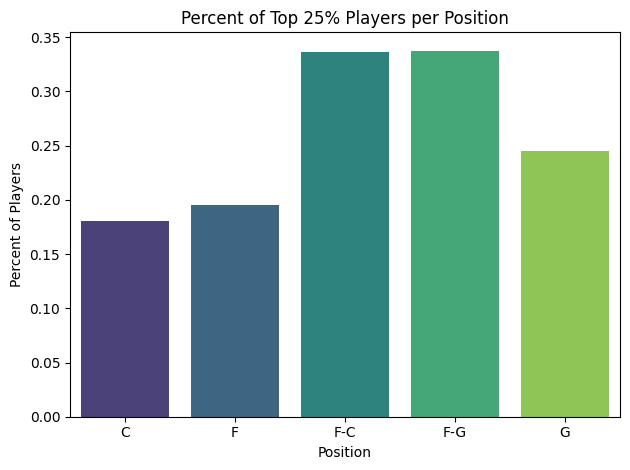

In [35]:
position_top_25_count = nba_players_df[nba_players_df['top_player'] == 'top_25_player'].groupby('position')['top_player'].count()
position_total_count = nba_players_df.groupby('position').size()
position_proportion_top_25 = position_top_25_count / position_total_count
print(position_proportion_top_25)

sns.barplot(x=position_proportion_top_25.index, y=position_proportion_top_25.values, hue=position_proportion_top_25.index, legend=False, palette='viridis')
plt.title("Percent of Top 25% Players per Position")
plt.ylabel("Percent of Players")
plt.xlabel("Position")
plt.tight_layout()


## Success According to College

college
University of Kentucky                        30
University of California, Los Angeles         27
Duke University                               20
University of North Carolina                  19
University of Michigan                        18
University of Arizona                         17
Michigan State University                     14
University of Notre Dame                      13
Georgia Institute of Technology               13
Indiana University                            13
Ohio State University                         12
University of Kansas                          12
University of Florida                         11
University of Southern California             11
St. John's University                         11
Wake Forest University                        10
Marquette University                          10
Villanova University                          10
University of Illinois at Urbana-Champaign     9
University of Washington                       9
Name: top_pl

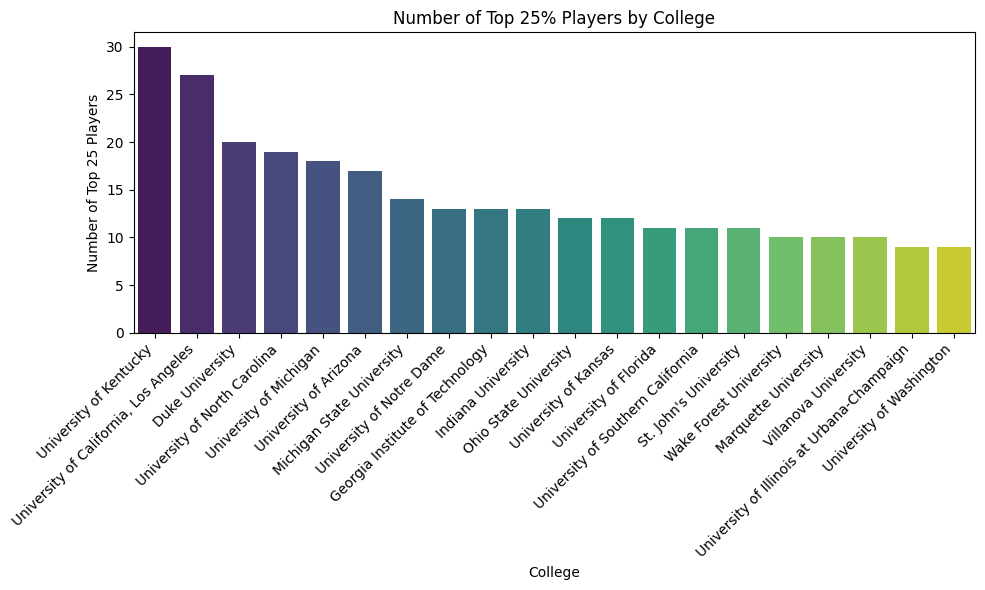

In [36]:
college_top_25_count = nba_players_df[nba_players_df['top_player'] == 'top_25_player'].groupby('college')['top_player'].count().sort_values(ascending=False).head(20)
print(college_top_25_count)

plt.figure(figsize=(10, 6))
sns.barplot(x=college_top_25_count.index, y=college_top_25_count.values, hue=college_top_25_count.index, legend=False, palette='viridis')
plt.title('Number of Top 25% Players by College')
plt.xlabel('College')
plt.ylabel('Number of Top 25 Players')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


In [41]:
college_top_25 = nba_players_df[nba_players_df['top_player'] == 'top_25_player']
num_with_college = len(college_top_25[college_top_25['college'].notna()])
num_without_college = len(college_top_25[college_top_25['college'].isna()])
print(f'Number of players in top 25 with a college: {num_with_college}')
print(f'Number of players in top 25 without a college: {num_without_college}')
print(f'Percent of players in top 25 that went to college: {num_with_college / len(college_top_25)}')


Number of players in top 25 with a college: 826
Number of players in top 25 without a college: 104
Percent of players in top 25 that went to college: 0.8881720430107527
